In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

python_file_path = "../data/dataset.csv"

In [2]:
data = pd.read_csv(python_file_path, index_col='transaction_date', parse_dates=True)
data.sort_values(by=['transaction_date'], ascending=True, inplace=True)

In [3]:
data

,spend
transaction_date,
2021-01-02,4.337302e+06
2021-01-03,3.795543e+06
2021-01-04,4.481645e+06
2021-01-05,4.292265e+06
2021-01-06,4.295346e+06
...,...
2023-12-27,3.438251e+06
2023-12-28,3.577079e+06
2023-12-29,3.906622e+06


In [4]:
data.describe()

,spend
count,1.091000e+03
mean,4.721010e+06
std,7.276578e+05
min,2.473514e+00
25%,4.280151e+06
50%,4.767960e+06
75%,5.156066e+06
max,7.662061e+06


# Data Visualisation
For data visualisation, I have used Looker for better understanding. Here is a link to the interactive display
https://lookerstudio.google.com/reporting/4aa09cf8-4835-48ec-a13b-4bc496f45f6c

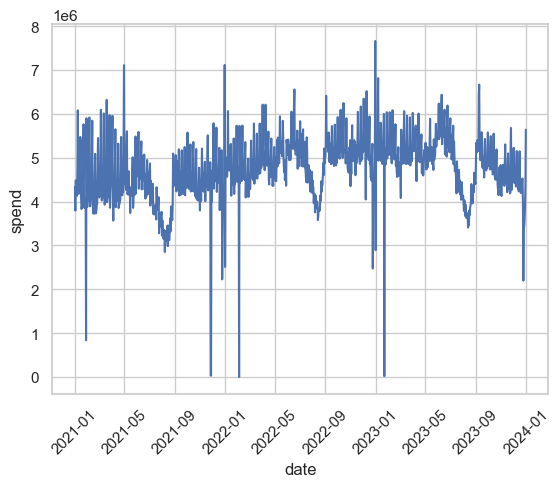

In [5]:
sns.set(style="whitegrid", color_codes=True)
plt.ylabel('spend')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.plot(data)

In [6]:
index = data.index
print("Are there only unique transaction dates: ", index.is_unique)

Are there only unique transaction dates:  True


In [7]:
df = data.copy()

In [8]:
df.columns

Index(['spend'], dtype='object')

## Missing data
* 365x3 = 1095 data points should have been in the dataset, but we have only 1091 rows.
* Thus, the sales data for 4 dates is missing.

In [9]:
# search of missing transaction_dates
missing_dates = pd.DataFrame(pd.date_range(start = '2021-01-01', end = '2023-12-31' ).difference(data.index))
missing_dates['day_of_week'] = missing_dates[0].apply(lambda x: x.strftime("%A"))
missing_dates


,0,day_of_week
0,2021-01-01,Friday
1,2022-05-22,Sunday
2,2022-05-31,Tuesday
3,2023-06-21,Wednesday


# Missing data
* for the above 4 transaction dates, where data is missing

In [10]:
# Create a full date range

start_date = data.index.min()
end_date = data.index.max()
full_date_range = pd.date_range(start='2021-01-01', end='2023-12-31')

# Reindex the DataFrame to include missing dates
data = data.reindex(full_date_range)

# Interpolate missing 'spend' values
data['spend'].interpolate(method='linear', inplace=True, )

# Reset index to make 'transaction_date' a column again
data = data.reset_index()
data.rename(columns={'index': 'transaction_date'}, inplace=True)

/var/folders/6x/mpnm8y_x5vqffz8srh3dj1g00000gn/T/ipykernel_77453/3018480724.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['spend'].interpolate(method='linear', inplace=True, )


In [11]:
data

,transaction_date,spend
0,2021-01-01,NaN
1,2021-01-02,4.337302e+06
2,2021-01-03,3.795543e+06
3,2021-01-04,4.481645e+06
4,2021-01-05,4.292265e+06
...,...,...
1090,2023-12-27,3.438251e+06
1091,2023-12-28,3.577079e+06
1092,2023-12-29,3.906622e+06
1093,2023-12-30,4.380962e+06


In [15]:
# apply a linear scale for data of Jan 1st 2021 using the formula: 
# spend(2021-01-01)  =  spend(2022-01-01)*( spend(2021-01-02) /spend(2022-01-02) )
# **could do this better by changing the index**
res = (data[data['transaction_date'] == '2022-01-01'].spend.values[0])*(data[data['transaction_date'] == '2021-01-02'].spend.values[0]/data[data['transaction_date'] == '2022-01-02'].spend.values[0])
print(res)

2415355.556865551


In [16]:
# set the spend data computed from the step above as 
data.at[0, 'spend'] = res

In [17]:
data[data['transaction_date'] == missing_dates[0][0]]

,transaction_date,spend
0,2021-01-01,2.415356e+06


In [18]:
# Detecting outliers
# Method 1: Calculate IQR
df = data.copy()
Q1 = df['spend'].quantile(0.25)
Q3 = df['spend'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_IQR = df[(df['spend'] < lower_bound) | (df['spend'] > upper_bound)]
# Flag outliers
df['is_outlier'] = (df['spend'] < lower_bound) | (df['spend'] > upper_bound)

In [19]:
outliers_IQR

,transaction_date,spend
0,2021-01-01,2.415356e+06
28,2021-01-29,8.404893e+05
120,2021-05-01,7.112337e+06
219,2021-08-08,2.851597e+06
330,2021-11-27,3.173582e+04
331,2021-11-28,3.294760e+04
358,2021-12-25,2.227253e+06
364,2021-12-31,7.117243e+06
365,2022-01-01,2.510053e+06
399,2022-02-04,2.473514e+00


In [20]:
outliers_IQR = outliers_IQR.reset_index()
outliers_IQR['week_day'] = outliers_IQR['transaction_date'].apply(lambda x: x.strftime("%A"))
outliers_IQR

,index,transaction_date,spend,week_day
0,0,2021-01-01,2.415356e+06,Friday
1,28,2021-01-29,8.404893e+05,Friday
2,120,2021-05-01,7.112337e+06,Saturday
3,219,2021-08-08,2.851597e+06,Sunday
4,330,2021-11-27,3.173582e+04,Saturday
5,331,2021-11-28,3.294760e+04,Sunday
6,358,2021-12-25,2.227253e+06,Saturday
7,364,2021-12-31,7.117243e+06,Friday
8,365,2022-01-01,2.510053e+06,Saturday
9,399,2022-02-04,2.473514e+00,Friday


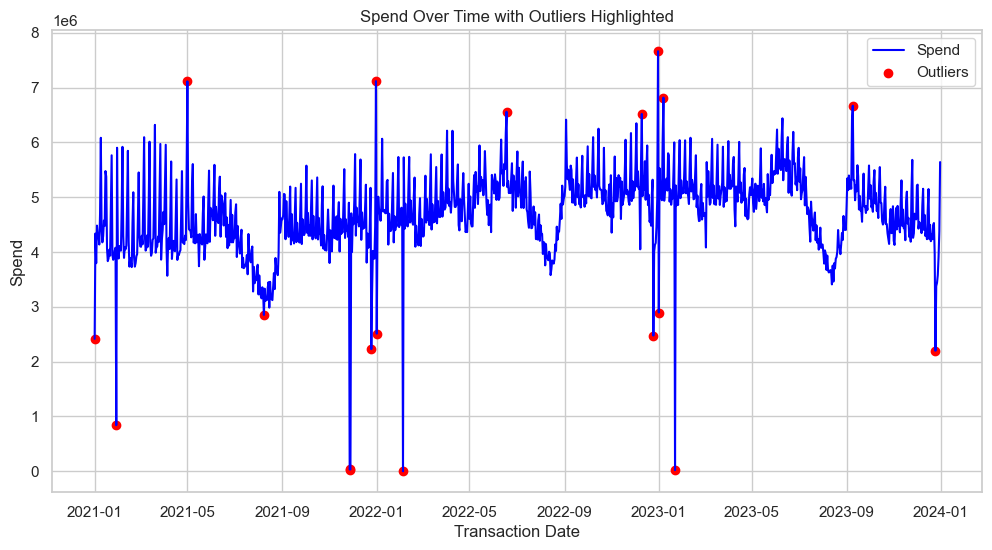

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(df['transaction_date'], df['spend'], label='Spend', color='blue')
plt.scatter(
    df.loc[df['is_outlier'], 'transaction_date'], 
    df.loc[df['is_outlier'], 'spend'], 
    color='red', 
    label='Outliers'
)

# Add labels and legend
plt.title('Spend Over Time with Outliers Highlighted')
plt.xlabel('Transaction Date')
plt.ylabel('Spend')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Method 2: z-score
# Calculate z-scores
from scipy import stats
df_zscore  = data.copy()
df_zscore['z_score'] = np.abs(stats.zscore(df_zscore['spend']))

# Define outlier threshold
threshold = 3
df_zscore['is_outlier'] = df_zscore['z_score'] > threshold

# Identify outliers
outliers_z = df_zscore[df_zscore['is_outlier']]

outliers_z = outliers_z.reset_index()
outliers_z['week_day'] = outliers_IQR['transaction_date'].apply(lambda x: x.strftime("%A"))
outliers_z


,index,transaction_date,spend,z_score,is_outlier,week_day
0,0,2021-01-01,2.415356e+06,3.157962,True,Friday
1,28,2021-01-29,8.404893e+05,5.315553,True,Friday
2,120,2021-05-01,7.112337e+06,3.276976,True,Saturday
3,330,2021-11-27,3.173582e+04,6.423558,True,Sunday
4,331,2021-11-28,3.294760e+04,6.421898,True,Saturday
5,358,2021-12-25,2.227253e+06,3.415666,True,Sunday
6,364,2021-12-31,7.117243e+06,3.283697,True,Saturday
7,365,2022-01-01,2.510053e+06,3.028224,True,Friday
8,399,2022-02-04,2.473514e+00,6.467033,True,Saturday
9,723,2022-12-25,2.474910e+06,3.076371,True,Friday


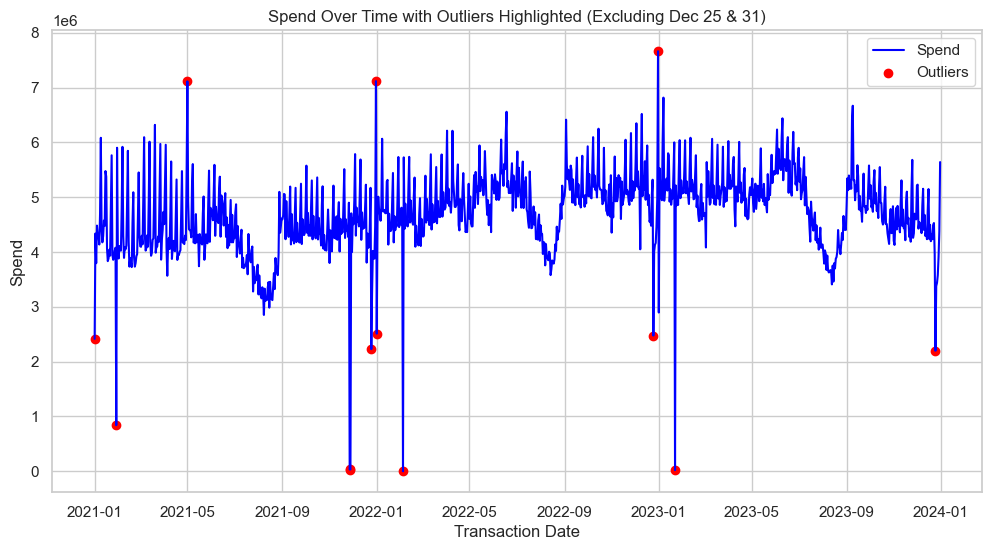

In [23]:
# Plot the data
plt.figure(figsize=(12, 6))
df_zscore = df_zscore.reset_index()
plt.plot(df_zscore['transaction_date'], df_zscore['spend'], label='Spend', color='blue')
plt.scatter(
    df_zscore.loc[df_zscore['is_outlier'], 'transaction_date'],
    df_zscore.loc[df_zscore['is_outlier'], 'spend'],
    color='red',
    label='Outliers'
)

# Add labels and legend
plt.title('Spend Over Time with Outliers Highlighted (Excluding Dec 25 & 31)')
plt.xlabel('Transaction Date')
plt.ylabel('Spend')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
#Method 3: seasonal decomposition
decomposition = seasonal_decompose(data['spend'], model='additive', period=365)

In [25]:
# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

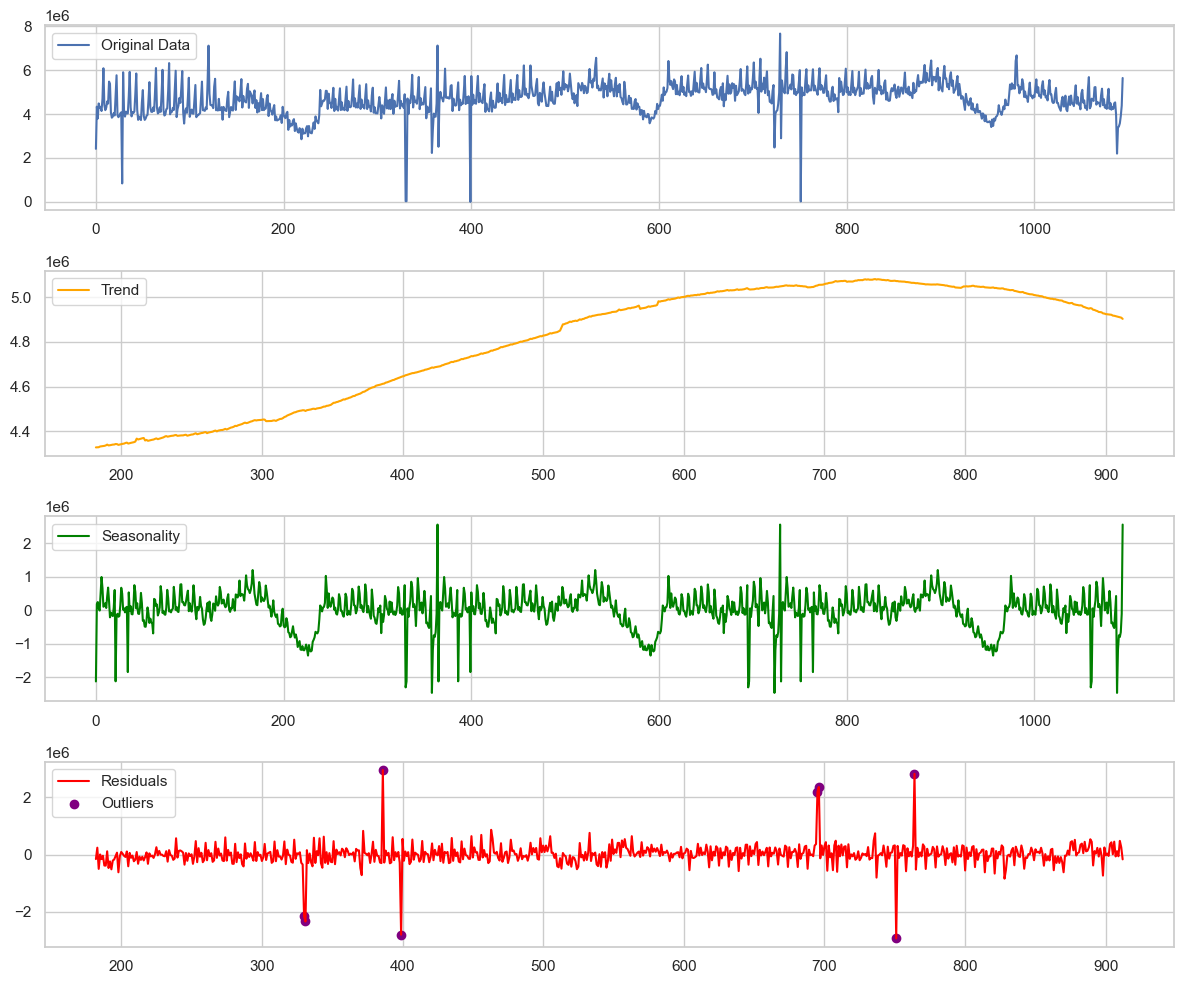

Detected Outliers:
330   -2.156112e+06
331   -2.334034e+06
386    2.953864e+06
399   -2.794430e+06
695    2.184513e+06
696    2.362435e+06
751   -2.925464e+06
764    2.822830e+06
Name: resid, dtype: float64


In [26]:
# Define threshold for outlier detection (e.g., 3 standard deviations)
threshold = 3 * np.std(residual.dropna())

# Identify outliers
outliers = residual[(residual > threshold) | (residual < -threshold)]

# Plot the results
plt.figure(figsize=(12, 10))

plt.subplot(411)
plt.plot(data['spend'], label='Original Data')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.scatter(outliers.index, outliers, color='purple', label='Outliers')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Print detected outliers
print("Detected Outliers:")
print(outliers)

In [27]:
outliers_stl = data[data.index.isin(outliers.index)]
outliers_stl = outliers_stl.reset_index()
outliers_stl

,index,transaction_date,spend
0,330,2021-11-27,3.173582e+04
1,331,2021-11-28,3.294760e+04
2,386,2022-01-22,5.441275e+06
3,399,2022-02-04,2.473514e+00
4,695,2022-11-27,4.929761e+06
5,696,2022-11-28,5.292929e+06
6,751,2023-01-22,2.088317e+04
7,764,2023-02-04,6.037112e+06


In [28]:
def exclude_dates(dataframe):
    dataframe['exclude'] = dataframe['transaction_date'].apply(lambda date: (date.month == 12 and date.day in [25, 31]) or (date.month == 1 and date.day in [1]))    
    return dataframe

In [29]:
outliers_IQR = exclude_dates(outliers_IQR)
# outliers_IQR.apply(lambda row: row.exclude)
outliers_IQR

,index,transaction_date,spend,week_day,exclude
0,0,2021-01-01,2.415356e+06,Friday,True
1,28,2021-01-29,8.404893e+05,Friday,False
2,120,2021-05-01,7.112337e+06,Saturday,False
3,219,2021-08-08,2.851597e+06,Sunday,False
4,330,2021-11-27,3.173582e+04,Saturday,False
5,331,2021-11-28,3.294760e+04,Sunday,False
6,358,2021-12-25,2.227253e+06,Saturday,True
7,364,2021-12-31,7.117243e+06,Friday,True
8,365,2022-01-01,2.510053e+06,Saturday,True
9,399,2022-02-04,2.473514e+00,Friday,False


In [30]:
outliers_IQR[~outliers_IQR['exclude']]

,index,transaction_date,spend,week_day,exclude
1,28,2021-01-29,8.404893e+05,Friday,False
2,120,2021-05-01,7.112337e+06,Saturday,False
3,219,2021-08-08,2.851597e+06,Sunday,False
4,330,2021-11-27,3.173582e+04,Saturday,False
5,331,2021-11-28,3.294760e+04,Sunday,False
9,399,2022-02-04,2.473514e+00,Friday,False
10,533,2022-06-18,6.558159e+06,Saturday,False
11,708,2022-12-10,6.517950e+06,Saturday,False
15,736,2023-01-07,6.816068e+06,Saturday,False
16,751,2023-01-22,2.088317e+04,Sunday,False


In [31]:
outliers_z = exclude_dates(outliers_z)
outliers_z

,index,transaction_date,spend,z_score,is_outlier,week_day,exclude
0,0,2021-01-01,2.415356e+06,3.157962,True,Friday,True
1,28,2021-01-29,8.404893e+05,5.315553,True,Friday,False
2,120,2021-05-01,7.112337e+06,3.276976,True,Saturday,False
3,330,2021-11-27,3.173582e+04,6.423558,True,Sunday,False
4,331,2021-11-28,3.294760e+04,6.421898,True,Saturday,False
5,358,2021-12-25,2.227253e+06,3.415666,True,Sunday,True
6,364,2021-12-31,7.117243e+06,3.283697,True,Saturday,True
7,365,2022-01-01,2.510053e+06,3.028224,True,Friday,True
8,399,2022-02-04,2.473514e+00,6.467033,True,Saturday,False
9,723,2022-12-25,2.474910e+06,3.076371,True,Friday,True


In [32]:
outliers_z[~outliers_z['exclude']]

,index,transaction_date,spend,z_score,is_outlier,week_day,exclude
1,28,2021-01-29,8.404893e+05,5.315553,True,Friday,False
2,120,2021-05-01,7.112337e+06,3.276976,True,Saturday,False
3,330,2021-11-27,3.173582e+04,6.423558,True,Sunday,False
4,331,2021-11-28,3.294760e+04,6.421898,True,Saturday,False
8,399,2022-02-04,2.473514e+00,6.467033,True,Saturday,False
11,751,2023-01-22,2.088317e+04,6.438426,True,Saturday,False


In [33]:
outliers_stl = exclude_dates(outliers_stl)
outliers_stl

,index,transaction_date,spend,exclude
0,330,2021-11-27,3.173582e+04,False
1,331,2021-11-28,3.294760e+04,False
2,386,2022-01-22,5.441275e+06,False
3,399,2022-02-04,2.473514e+00,False
4,695,2022-11-27,4.929761e+06,False
5,696,2022-11-28,5.292929e+06,False
6,751,2023-01-22,2.088317e+04,False
7,764,2023-02-04,6.037112e+06,False


# Anomalies conclusion
From the above three outlier techniques and based on business knowledge, it can be concluded that the following dates have outliers:
* 2021-01-29 : Low spend
* 2021-05-01 : high spend given it's a holiday in france
* 2021-08-08 : potential outlier
* 2021-11-27 : Low spend
* 2021-11-28 : Low spend
* 2022-02-04 : Low spend
* 2023-01-22 : Low spend


In [34]:
data.set_index('transaction_date', inplace=True)

In [35]:
# replace by the mean sales for the same day of the week for the two years
# here there is a caveat, because we are using the future data and potentially the estimation is biased
data.loc['2021-01-29'].spend = np.mean([data.loc['2022-01-28'].spend, data.loc['2023-01-27'].spend])
data.loc['2021-05-01'].spend = np.mean([data.loc['2022-05-01'].spend, data.loc['2023-05-01'].spend])
data.loc['2021-11-27'].spend = np.mean([data.loc['2022-11-26'].spend, data.loc['2023-11-25'].spend])
data.loc['2021-11-28'].spend = np.mean([data.loc['2022-11-27'].spend, data.loc['2023-11-26'].spend])

In [36]:
# replace by the mean sales for the same day of the week for the two years
data.loc['2022-02-04'].spend = np.mean([data.loc['2021-02-05'].spend, data.loc['2023-02-03'].spend])
data.loc['2022-02-04'].spend

np.float64(5138596.105731592)

In [37]:
# replace by the mean sales for the same day of the week for the last two years
data.loc['2023-01-22'].spend = np.mean([data.loc['2021-01-24'].spend, data.loc['2022-01-23'].spend])
data.loc['2023-01-22'].spend

np.float64(4058913.25677918)

In [38]:
data.to_csv('../data/cleaned_data/data_cleaned.csv')

# Forecasting

In [39]:
# Stationarity Test (Augmented Dickey-Fuller Test)
def adf_test(series, title=''):
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(f'Augmented Dickey-Fuller Test: {title}')
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion: Data is stationary")
    else:
        print("Conclusion: Data is non-stationary")

adf_test(data['spend'], title='Original Data')

# 3. Differencing to Achieve Stationarity
data['spend_diff'] = data['spend'] - data['spend'].shift(1)
data['spend_diff'].dropna(inplace=True)

# Stationarity test after differencing
adf_test(data['spend_diff'][1:], title='After First Difference')

Augmented Dickey-Fuller Test: Original Data
Test Statistic                   -3.646416
p-value                           0.004933
#Lags Used                       21.000000
Number of Observations Used    1073.000000
Critical Value (1%)              -3.436459
Critical Value (5%)              -2.864237
Critical Value (10%)             -2.568206
dtype: float64
Conclusion: Data is stationary
Augmented Dickey-Fuller Test: After First Difference
Test Statistic                -9.069073e+00
p-value                        4.351673e-15
#Lags Used                     2.000000e+01
Number of Observations Used    1.073000e+03
Critical Value (1%)           -3.436459e+00
Critical Value (5%)           -2.864237e+00
Critical Value (10%)          -2.568206e+00
dtype: float64
Conclusion: Data is stationary


## add features

In [40]:
df = data.copy()
df.drop(columns=['spend_diff'], inplace=True)
df.reset_index(inplace=True)


In [41]:
df

,transaction_date,spend
0,2021-01-01,2.415356e+06
1,2021-01-02,4.337302e+06
2,2021-01-03,3.795543e+06
3,2021-01-04,4.481645e+06
4,2021-01-05,4.292265e+06
...,...,...
1090,2023-12-27,3.438251e+06
1091,2023-12-28,3.577079e+06
1092,2023-12-29,3.906622e+06
1093,2023-12-30,4.380962e+06


In [42]:
from vacances_scolaires_france import SchoolHolidayDates
school_holidays = SchoolHolidayDates()

In [43]:
holidays = pd.DataFrame(school_holidays.data).transpose()

In [44]:
holidays

,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances
1990-10-27,1990-10-27,True,True,True,Vacances de la Toussaint
1990-10-28,1990-10-28,True,True,True,Vacances de la Toussaint
1990-10-29,1990-10-29,True,True,True,Vacances de la Toussaint
1990-10-30,1990-10-30,True,True,True,Vacances de la Toussaint
1990-10-31,1990-10-31,True,True,True,Vacances de la Toussaint
...,...,...,...,...,...
2026-08-26,2026-08-26,True,True,True,Vacances d'été
2026-08-27,2026-08-27,True,True,True,Vacances d'été
2026-08-28,2026-08-28,True,True,True,Vacances d'été
2026-08-29,2026-08-29,True,True,True,Vacances d'été


In [45]:
import datetime
df['is_holiday'] = df['transaction_date'].apply(lambda date: school_holidays.is_holiday(datetime.date(date.year, date.month, date.day)))

In [46]:
df

,transaction_date,spend,is_holiday
0,2021-01-01,2.415356e+06,True
1,2021-01-02,4.337302e+06,True
2,2021-01-03,3.795543e+06,True
3,2021-01-04,4.481645e+06,False
4,2021-01-05,4.292265e+06,False
...,...,...,...
1090,2023-12-27,3.438251e+06,True
1091,2023-12-28,3.577079e+06,True
1092,2023-12-29,3.906622e+06,True
1093,2023-12-30,4.380962e+06,True


In [47]:
holidays = df[df['is_holiday']].copy()
df.drop(columns=['is_holiday'], inplace=True)

In [48]:
df.rename(columns={'transaction_date': 'ds', 'spend': 'y'}, inplace=True)
df

,ds,y
0,2021-01-01,2.415356e+06
1,2021-01-02,4.337302e+06
2,2021-01-03,3.795543e+06
3,2021-01-04,4.481645e+06
4,2021-01-05,4.292265e+06
...,...,...
1090,2023-12-27,3.438251e+06
1091,2023-12-28,3.577079e+06
1092,2023-12-29,3.906622e+06
1093,2023-12-30,4.380962e+06


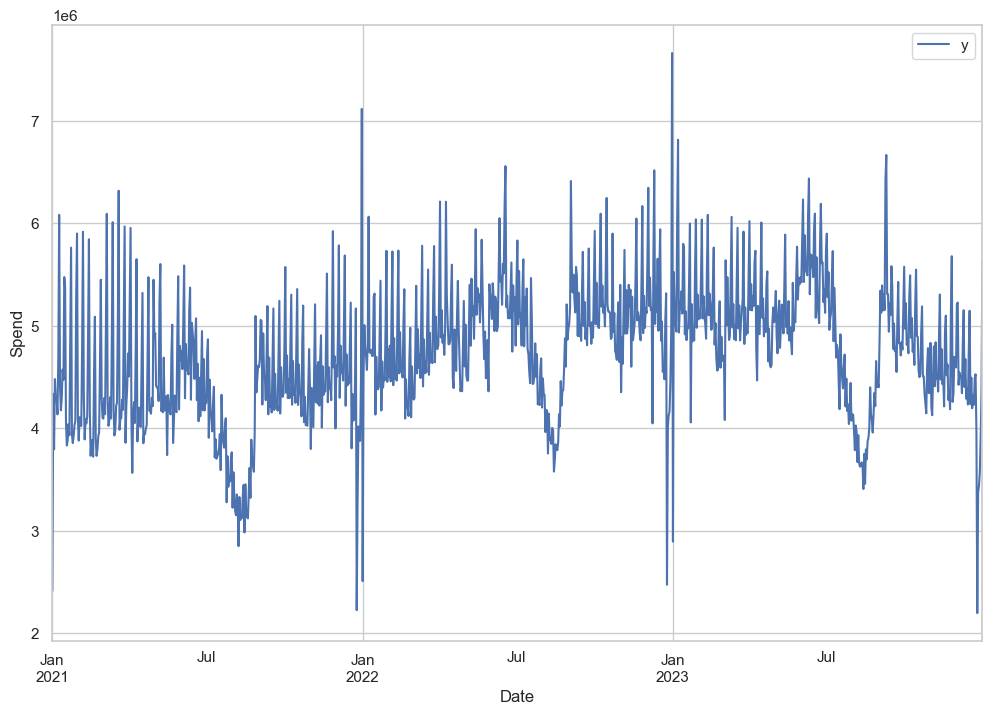

In [49]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Spend')
ax.set_xlabel('Date')

plt.show()

In [51]:
from prophet import Prophet
# set the uncertainty interval to 95% (the Prophet default is 80%)
m = Prophet(interval_width=0.95,)

In [52]:
m.add_country_holidays(country_name='FR')
m.train_holiday_names

In [53]:
m.fit(df)

14:02:19 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
future_dates = m.make_future_dataframe(periods=30, freq='D')
future_dates

,ds
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05
...,...
1120,2024-01-26
1121,2024-01-27
1122,2024-01-28
1123,2024-01-29


In [55]:
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1120,2024-01-26,4.798156e+06,4.241796e+06,5.409776e+06
1121,2024-01-27,5.202615e+06,4.649219e+06,5.771207e+06
1122,2024-01-28,4.289350e+06,3.704628e+06,4.825553e+06
1123,2024-01-29,4.558991e+06,4.015913e+06,5.157809e+06
1124,2024-01-30,4.326925e+06,3.716343e+06,4.934276e+06


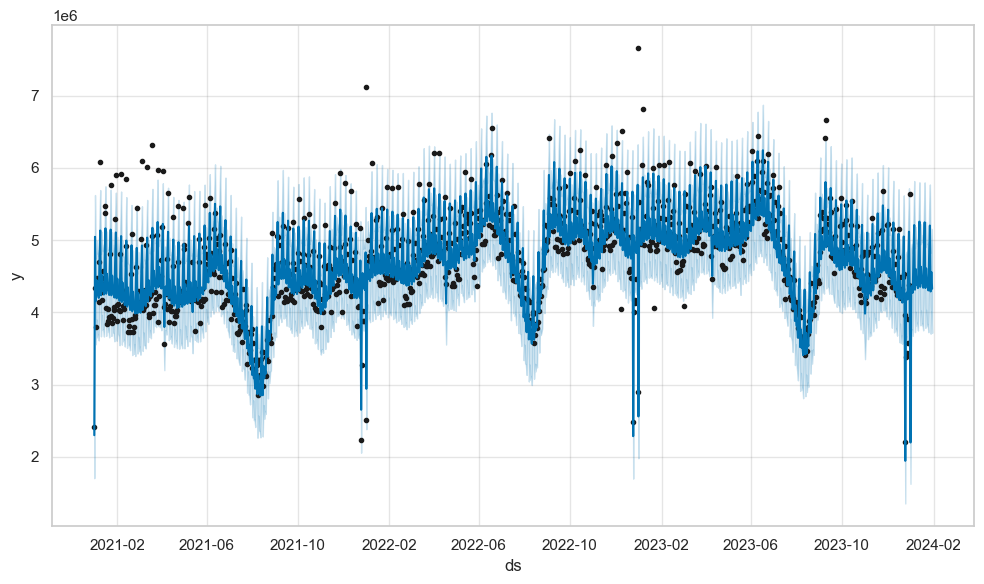

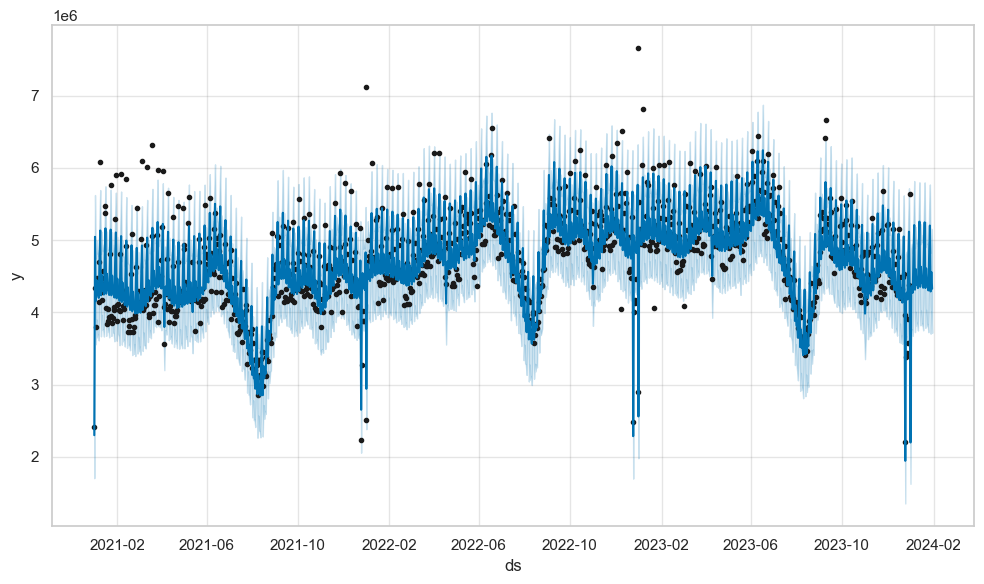

In [56]:
m.plot(forecast, uncertainty=True)

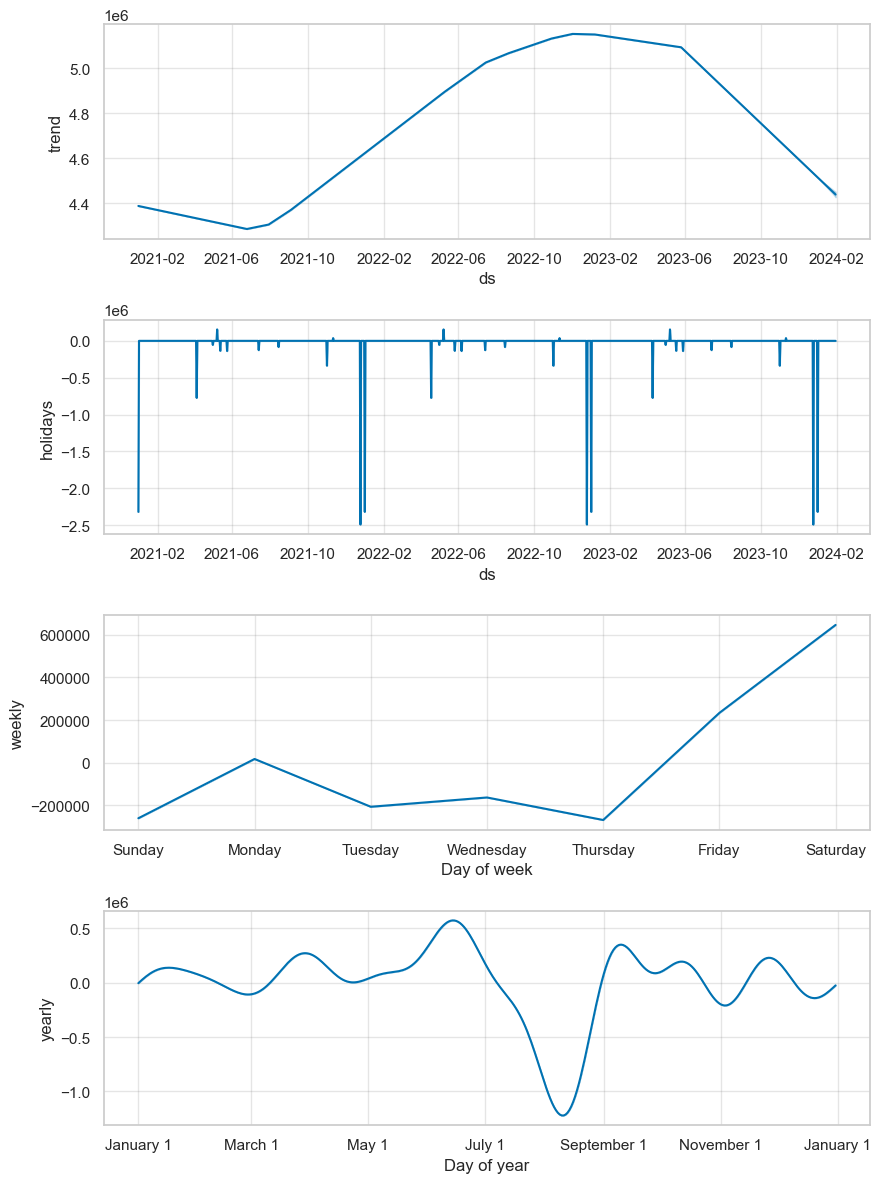

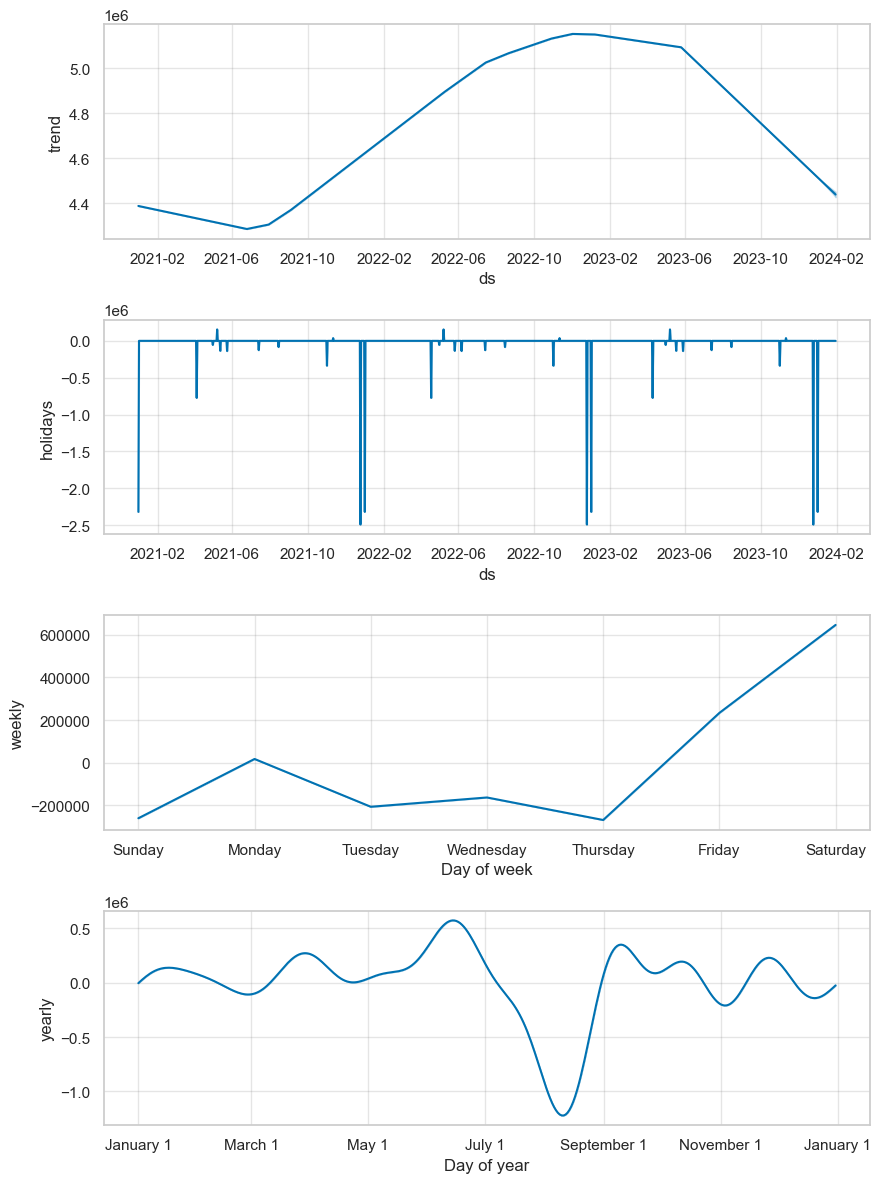

In [57]:
m.plot_components(forecast)

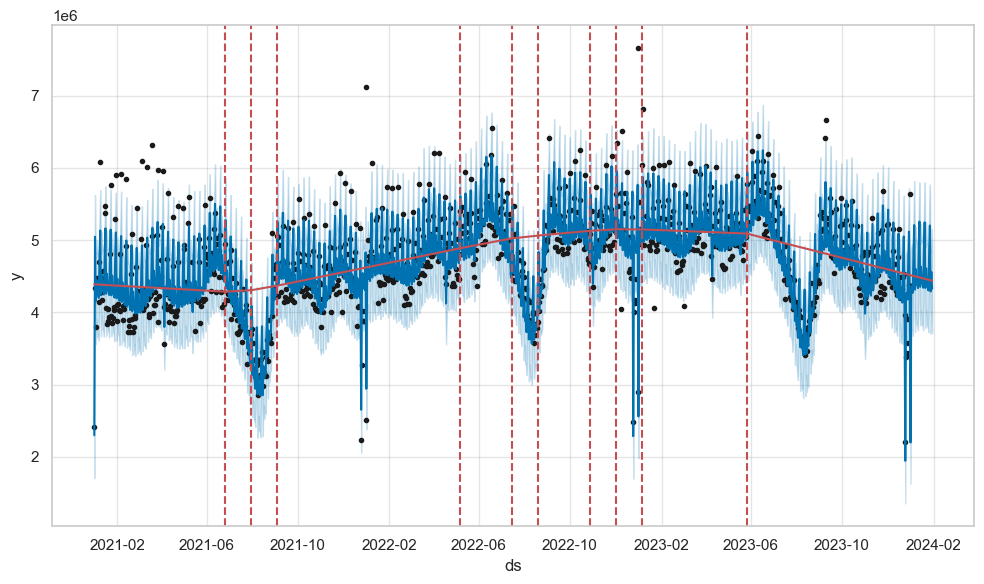

In [58]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


In [59]:
m.changepoints

35    2021-02-05
70    2021-03-12
105   2021-04-16
140   2021-05-21
175   2021-06-25
210   2021-07-30
245   2021-09-03
280   2021-10-08
315   2021-11-12
350   2021-12-17
385   2022-01-21
420   2022-02-25
455   2022-04-01
490   2022-05-06
525   2022-06-10
560   2022-07-15
595   2022-08-19
630   2022-09-23
665   2022-10-28
700   2022-12-02
735   2023-01-06
770   2023-02-10
805   2023-03-17
840   2023-04-21
875   2023-05-26
Name: ds, dtype: datetime64[ns]

14:06:04 - cmdstanpy - INFO - Chain [1] start processing
14:06:04 - cmdstanpy - INFO - Chain [1] done processing


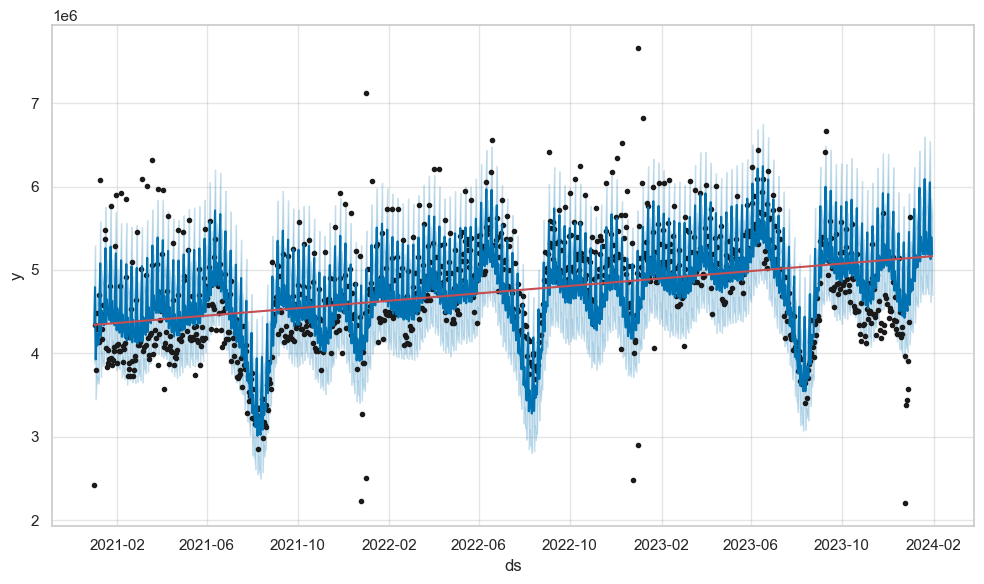

In [60]:
pro_change = Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [61]:
# train model and grid search
import itertools
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0, 5.0],
    'seasonality_prior_scale': [0.001, 0.01, 0.1, 1.0],
}

cutoffs = pd.to_datetime(['2022-10-10', '2023-04-10', '2023-10-10'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])


14:06:18 - cmdstanpy - INFO - Chain [1] start processing
14:06:18 - cmdstanpy - INFO - Chain [1] done processing
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing
14:06:19 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1]

In [828]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale           rmse
0                      0.01                    0.001  431777.102559
1                      0.01                    0.010  357857.935820
2                      0.01                    0.100  359744.249152
3                      0.01                    1.000  356081.431856
4                      0.10                    0.001  353574.952298
5                      0.10                    0.010  282080.249744
6                      0.10                    0.100  291350.047047
7                      0.10                    1.000  290642.595921
8                      0.50                    0.001  349431.023757
9                      0.50                    0.010  268850.013023
10                     0.50                    0.100  280297.719256
11                     0.50                    1.000  281321.717264
12                     1.00                    0.001  349922.959529
13                     1.00                    0

In [830]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


02:16:07 - cmdstanpy - INFO - Chain [1] start processing
02:16:07 - cmdstanpy - INFO - Chain [1] done processing


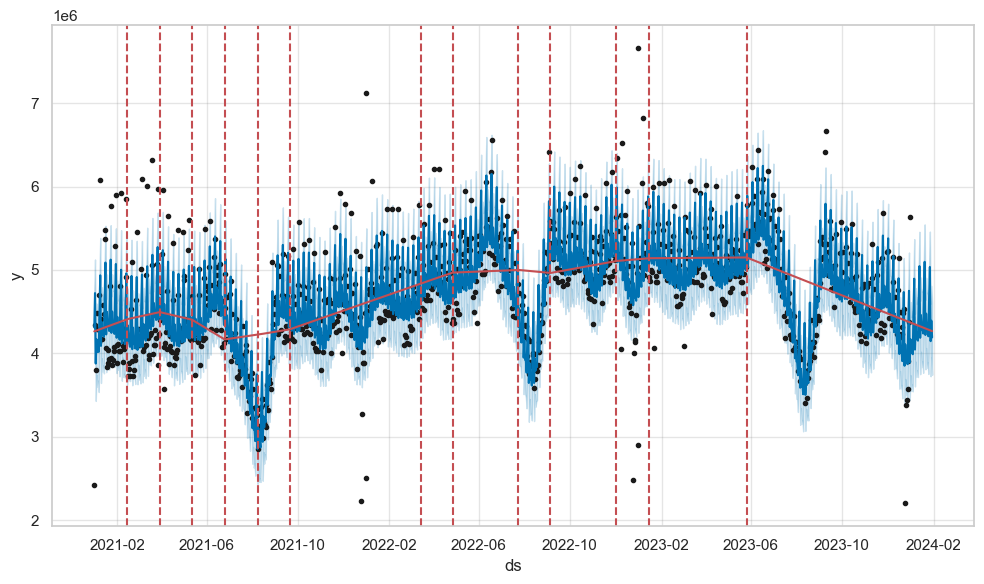

In [853]:
pro_change = Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=1, seasonality_prior_scale=0.01)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)